### Importing necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Reshape, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Model, save_model, load_model
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2

import os
from time import time

Using TensorFlow backend.


### Creating function that allows to load datasets

In [2]:
direct = '/home/adam/Pulpit/python/jupyter_notebook/algorytmy_maszynowe/projekty/Histopathologic_cancer_detection/cell_images'

categories = ['Parasitized', 'Uninfected']

In [3]:
data = []

def create_training_data():
    

    categories = ['Parasitized', 'Uninfected']
    
    for category in categories:
        path = os.path.join(direct, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (90, 90))
                data.append([new_array, class_num])
            except Exception as e:
                pass

In [4]:
create_training_data()

### Dividing data into features and labels

In [5]:
X = []
y = []

for img, label in data:
        X.append(img)
        y.append(label)

X = np.array(X).reshape(-1, 90, 90, 3)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### Visualizing some samples to analyse problem

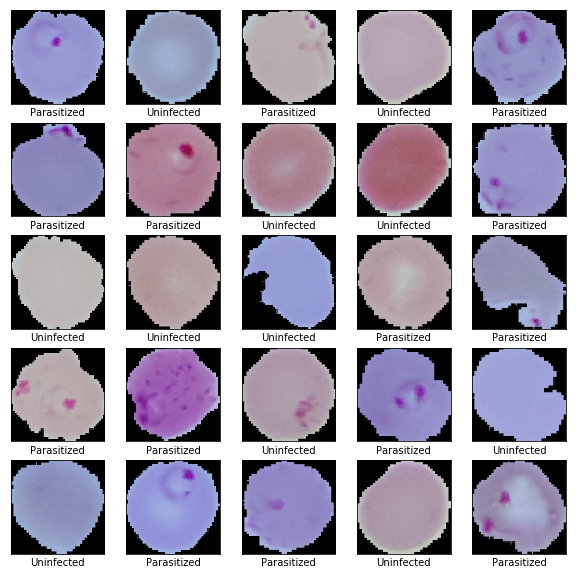

In [7]:
plt.figure(figsize = (10, 10))

for i in range(1, 26, 1):
    plt.subplot(5, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(categories[y_train[i]])
plt.show()

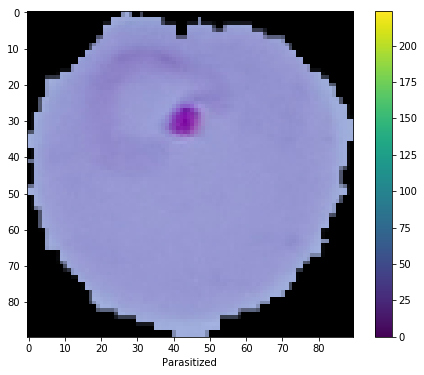

In [8]:
plt.figure(figsize = (8, 6))
plt.imshow(X_train[1])
plt.xlabel(categories[y_train[17]])
plt.colorbar()
plt.grid(False)
plt.show()

### Creating image data generators to avoid problem with overfitting

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20, width_shift_range = 0.2, 
                                  height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True, fill_mode = 'nearest', validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

### Defining datasets coming from generators

In [10]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 32, subset = 'training')

In [11]:
validation_generator = train_datagen.flow(X_train, y_train, batch_size = 32, subset = 'validation')

In [25]:
test_generator = test_datagen.flow(X_test, y_test, batch_size = 32)

### Choosing Adam optimalizator

In [12]:
adam_opt = Adam(lr = 0.0001)

### Creating convolutional model and compiling it

In [18]:
def create_model():

    inp = Input(shape = (90, 90, 3))
    
    x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu',
          kernel_initializer = 'he_normal', data_format='channels_last')(inp)
    x = MaxPooling2D(pool_size = (2, 2), padding = 'valid')(x)
    
    x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu',
          kernel_initializer = 'he_normal')(x)
    x = MaxPooling2D(pool_size = (2, 2), padding = 'valid')(x)
    x = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'valid', activation = 'relu',
          kernel_initializer = 'he_normal')(x)
    
    x = Flatten()(x)
    x = Dense(256, kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(256, activation = 'relu', kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
  
    output = Dense(1, activation = 'sigmoid', kernel_initializer= 'he_normal')(x)
    
    model = Model(inputs = inp, outputs = output)
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [19]:
model = create_model()

### Defining callbacks

In [22]:
checkpoint = ModelCheckpoint(filepath = './modele/model'.format(int(time())), monitor = 'val_acc', 
                                           save_best_only = True, mode = 'max')

tensorboard = TensorBoard(log_dir='./graphs/graph'.format(int(time())), histogram_freq= 0, 
                                          write_graph= True, write_images = True, batch_size = 50)

earlystopping = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 8)

### Training model

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch = 603, epochs = 50, shuffle = True,
                               callbacks = [checkpoint, tensorboard, earlystopping],
                             validation_data = validation_generator, validation_steps = 130)

Epoch 1/50
603/603 [==============================] - 455s 754ms/step - loss: 0.6190 - acc: 0.6729 - val_loss: 0.5865 - val_acc: 0.5028
Epoch 2/50
603/603 [==============================] - 453s 752ms/step - loss: 0.2987 - acc: 0.8910 - val_loss: 0.2417 - val_acc: 0.9169
Epoch 3/50
603/603 [==============================] - 453s 751ms/step - loss: 0.2504 - acc: 0.9174 - val_loss: 0.2356 - val_acc: 0.9198
Epoch 4/50
603/603 [==============================] - 453s 751ms/step - loss: 0.2279 - acc: 0.9246 - val_loss: 0.2389 - val_acc: 0.9222
Epoch 5/50
603/603 [==============================] - 452s 749ms/step - loss: 0.2238 - acc: 0.9241 - val_loss: 0.2395 - val_acc: 0.9249
Epoch 6/50
603/603 [==============================] - 453s 750ms/step - loss: 0.2238 - acc: 0.9243 - val_loss: 0.2134 - val_acc: 0.9261
Epoch 7/50
603/603 [==============================] - 454s 753ms/step - loss: 0.2240 - acc: 0.9238 - val_loss: 0.1983 - val_acc: 0.9319
Epoch 8/50
603/603 [============================

### Evaluating trained model

In [28]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps = 173)

In [41]:
print('Test loss: %4.2f' % (test_loss))
print('Test accuracy: %4.2f' % (test_accuracy))

Test loss: 0.14
Test accuracy: 0.96


### Plotting history to analyse training stage

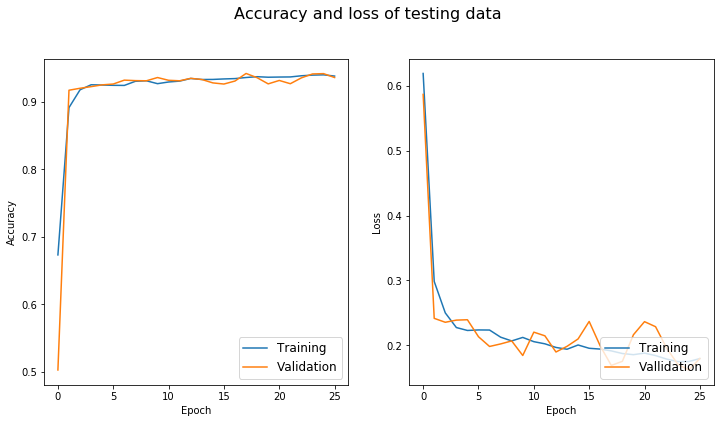

In [40]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.plot(history.history['acc'], label = 'Training')
plt.plot(history.history['val_acc'], label = 'Validation')
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = "Vallidation")
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle(t = 'Accuracy and loss of testing data', x = 0.5, y = 1, fontsize = 16)
plt.show()

### Saving trained model

In [ ]:
save_model(model, './final_model')

### Loading model to visualize indirect activation (in progress)

In [7]:
conv_model = load_model('./final_model')

In [8]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 88, 88, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 46208)             0         
__________

In [15]:
img_tensor = X_test[2] / 255. 
img_tensor = np.expand_dims(img_tensor, axis = 0)

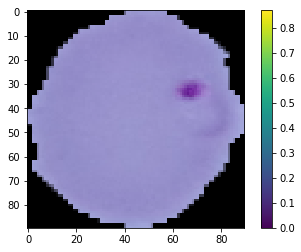

In [16]:
plt.imshow(img_tensor[0])
plt.colorbar()
plt.show()

In [19]:
conv_model.layers[:6]

In [24]:
layer_outputs = [layer.output for layer in conv_model.layers[:4]]
activation_model = Model(inputs = conv_model.input, outputs = layer_outputs)